# Time Series Analysis

Using a different time series data set (either from [FRED](https://fred.stlouisfed.org/) or elsewhere, go about the process of time series modeling. Specifically generate the following things:

1. Plot the time series, along with any logical or necessary differences to get a stationary dataset
2. Generate and interpret a PACF for the time series (and/or its differences)
3. Generate 5 ARIMA specifications and evaluate their efficacy at modeling your data
4. Finally choose one specification and make the case for that as a logical model for your dataset.

This should come in the form of a notebook with the necessary prose to explain your process. Remember to use the tools of text, visuals, and analysis to tell a clear and concise story with your data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt

from sklearn import linear_model

from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA

In [2]:
raw_data = pd.read_csv('~/src/data/fredData/dcoilwtico.csv')
raw_data.iloc[:10]

,DCOILWTICO,Unnamed: 1
0,lin,Dollars per Barrel
1,D,Daily
2,01/01/1900,1986-01-02 to 2019-04-01
3,Crude Oil Prices: West Texas Intermediate (WTI...,NaN
4,U.S. Energy Information Administration,NaN
5,date,value
6,01/02/1986,25.6
7,01/03/1986,26.0
8,01/06/1986,26.5
9,01/07/1986,25.9


In [3]:
raw_data.head()

,DCOILWTICO,Unnamed: 1
0,lin,Dollars per Barrel
1,D,Daily
2,01/01/1900,1986-01-02 to 2019-04-01
3,Crude Oil Prices: West Texas Intermediate (WTI...,NaN
4,U.S. Energy Information Administration,NaN


In [4]:
df = raw_data.drop([0, 1, 2, 3, 4 ,5])
df = df.reset_index(drop=True)
df = df.rename(columns={"DCOILWTICO": "date", "Unnamed: 1": "value"})
df.head()

,date,value
0,01/02/1986,25.6
1,01/03/1986,26.0
2,01/06/1986,26.5
3,01/07/1986,25.9
4,01/08/1986,25.9


In [5]:
df.dtypes

date     object
value    object
dtype: object

In [6]:
df.isnull().sum()

date       0
value    292
dtype: int64

In [7]:
# Convert oil price to a number, with coersion to throw NA's if conversion not possible.
df['price'] = pd.to_numeric(df.value, errors = 'coerce')

# Remove NA's.
df.dropna(inplace = True)

# Create date-based index.
df.index = pd.to_datetime(df.date)

# Removing "value".
df = df.drop(['value'], axis = 1)

# View.
df.head()

,date,price
date,,
1986-01-02,01/02/1986,25.6
1986-01-03,01/03/1986,26.0
1986-01-06,01/06/1986,26.5
1986-01-07,01/07/1986,25.9
1986-01-08,01/08/1986,25.9


In [8]:
df.dtypes

date      object
price    float64
dtype: object

## Viewing our data

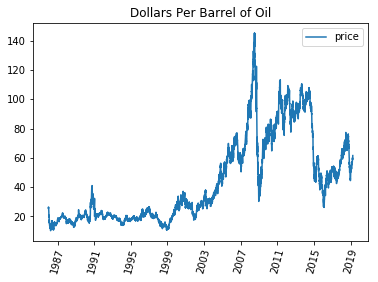

In [9]:
#plt.rcParams['figure.figsize'] = (15, 10)
plt.plot(df.index, df.price, '-')
plt.xticks(rotation=75)
plt.title('Dollars Per Barrel of Oil')
plt.legend()
plt.show()

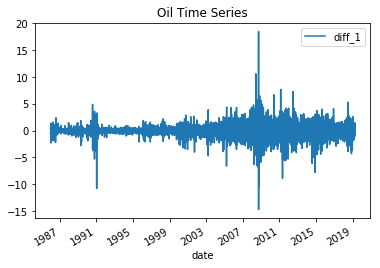

In [10]:
# Differencing

"""
Differencing: We need the data for ARIMA to be stationary. Differencing involves
subtracting each term from its following term. If there is a constant linear trend,
then that difference has a constant expectation.
"""

#plt.rcParams['figure.figsize'] = (15, 10)
df['diff_1'] = df.price - df.price.shift()
df.plot(y='diff_1')
plt.title('Oil Time Series')
plt.show()

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  if __name__ == '__main__':


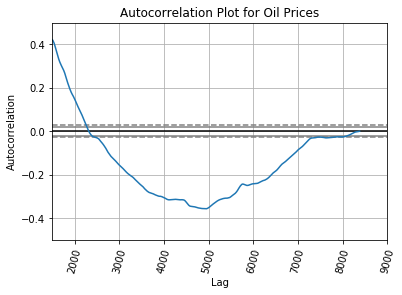

In [11]:
# Autocorrelation plot.
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

"""Autocorrelation plots used for checking randomness in time series. If time series is random,
 such autocorrelations should be near zero for any and all time-lag separations. If time series
 is non-random then one or more of the autocorrelations will be significantly non-zero."""

from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(df['price'])
plt.title("Autocorrelation Plot for Oil Prices")
plt.xlim(1500, 9000)
plt.ylim(-0.5, 0.5)
plt.xticks(rotation=75)
plt.show()

Dashed line is 99% confidence band, whereas grey lines are 95%. The higher the Lag, the more non-zero autocorrelations are present (see around ~8300), implying this aspect of our time series data is non-random. 

p-value == ~ 2300

Text(0.5,1,'Oil PACF')

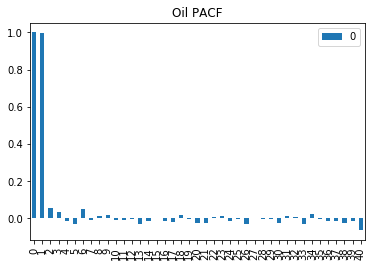

In [12]:
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(df.price))
x_acf.plot(kind='bar')
plt.title("Oil PACF")

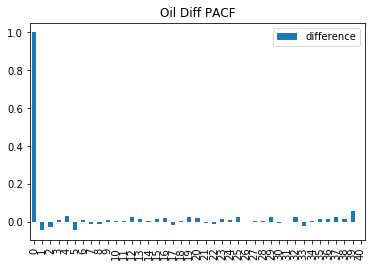

In [13]:
x_acf = pd.DataFrame(pacf(df.diff_1[1:])) #as first indexed val is NaN due to lag
x_acf.plot(kind='bar')
plt.title("Oil Diff PACF")
plt.legend(['difference'])

#### Interpretation
For above plots, 0 will always return 1, since the time series perfectly correlates itself. 

The first PACF (partial autocorrelation function) plot can be interpreted as that a third-order autoregression may be warranted since there are notable 

## ARIMA Models

In [14]:
def run_arima(ar, i, ma, vals):
    from statsmodels.tsa.arima_model import ARIMA
    model = ARIMA(vals, order=(ar, i, ma))
    model_fit = model.fit()
    summary = model_fit.summary()
    residuals = model_fit.resid.describe()
    print(summary)
    print('Residuals Description:')
    print(residuals)
    from statsmodels.tsa.arima_model import ARIMAResults
    arimaAic = ARIMAResults.aic(model_fit)
    arimaVals = ar, i, ma
    returnValue = [arimaVals, arimaAic]
    return returnValue

In [15]:
import itertools

tuningVals = list(itertools.permutations([0, 1, 2, 3, 4, 5], 3))
#tuningVals = list(itertools.permutations([0, 1, 2], 3))

arima_params = []
aic = []

for p, d, q in tuningVals:
    try:
        output = run_arima(p, d, q, df.price)
        arima_params.append(output[0])
        aic.append(output[1])
    except:
        pass

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\s

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 8380
Model:                 ARIMA(0, 1, 2)   Log Likelihood              -13026.502
Method:                       css-mle   S.D. of innovations              1.145
Date:                Thu, 11 Apr 2019   AIC                          26061.005
Time:                        18:07:58   BIC                          26089.139
Sample:                             1   HQIC                         26070.612
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0043      0.012      0.367      0.714      -0.019       0.027
ma.L1.D.price    -0.0454      0.011     -4.153      0.000      -0.067      -0.024
ma.L2.D.price    -0.0217      0.011     

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 8380
Model:                 ARIMA(0, 1, 4)   Log Likelihood              -13023.236
Method:                       css-mle   S.D. of innovations              1.145
Date:                Thu, 11 Apr 2019   AIC                          26058.472
Time:                        18:07:59   BIC                          26100.674
Sample:                             1   HQIC                         26072.884
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0043      0.012      0.353      0.724      -0.020       0.028
ma.L1.D.price    -0.0438      0.011     -3.989      0.000      -0.065      -0.022
ma.L2.D.price    -0.0221      0.011     

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 8380
Model:                 ARIMA(0, 1, 5)   Log Likelihood              -13014.952
Method:                       css-mle   S.D. of innovations              1.144
Date:                Thu, 11 Apr 2019   AIC                          26043.905
Time:                        18:07:59   BIC                          26093.140
Sample:                             1   HQIC                         26060.718
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0043      0.012      0.368      0.713      -0.018       0.027
ma.L1.D.price    -0.0442      0.011     -4.047      0.000      -0.066      -0.023
ma.L2.D.price    -0.0235      0.011     

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.price   No. Observations:                 8379
Model:                 ARIMA(0, 2, 1)   Log Likelihood              -13040.876
Method:                       css-mle   S.D. of innovations              1.147
Date:                Thu, 11 Apr 2019   AIC                          26087.751
Time:                        18:08:01   BIC                          26108.852
Sample:                             2   HQIC                         26094.957
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -4.727e-08   5.18e-06     -0.009      0.993   -1.02e-05    1.01e-05
ma.L1.D2.price    -1.0000      0.000  -2892.334      0.000      -1.001      -0.999
                                    

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\s

                              ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                 8381
Model:                     ARMA(1, 2)   Log Likelihood              -13029.662
Method:                       css-mle   S.D. of innovations              1.145
Date:                Thu, 11 Apr 2019   AIC                          26069.325
Time:                        18:08:03   BIC                          26104.494
Sample:                             0   HQIC                         26081.335
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          43.7926     14.005      3.127      0.002      16.343      71.242
ar.L1.price     0.9993      0.000   2699.643      0.000       0.999       1.000
ma.L1.price    -0.0450      0.011     -4.119    

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                 8381
Model:                     ARMA(1, 3)   Log Likelihood              -13028.849
Method:                       css-mle   S.D. of innovations              1.145
Date:                Thu, 11 Apr 2019   AIC                          26069.699
Time:                        18:08:05   BIC                          26111.901
Sample:                             0   HQIC                         26084.110
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          43.7925     13.883      3.154      0.002      16.581      71.004
ar.L1.price     0.9993      0.000   2655.048      0.000       0.999       1.000
ma.L1.price    -0.0460      0.011     -4.204    

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                 8381
Model:                     ARMA(1, 4)   Log Likelihood              -13026.276
Method:                       css-mle   S.D. of innovations              1.144
Date:                Thu, 11 Apr 2019   AIC                          26066.552
Time:                        18:08:08   BIC                          26115.788
Sample:                             0   HQIC                         26083.366
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          43.8177     13.652      3.210      0.001      17.061      70.575
ar.L1.price     0.9992      0.000   2574.152      0.000       0.998       1.000
ma.L1.price    -0.0434      0.011     -3.950    

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                 8381
Model:                     ARMA(1, 5)   Log Likelihood              -13018.127
Method:                       css-mle   S.D. of innovations              1.143
Date:                Thu, 11 Apr 2019   AIC                          26052.255
Time:                        18:08:12   BIC                          26108.524
Sample:                             0   HQIC                         26071.470
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          43.7857     14.045      3.117      0.002      16.257      71.314
ar.L1.price     0.9993      0.000   2707.711      0.000       0.999       1.000
ma.L1.price    -0.0438      0.011     -4.013    

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  

                             ARIMA Model Results                              
Dep. Variable:               D2.price   No. Observations:                 8379
Model:                 ARIMA(1, 2, 3)   Log Likelihood              -13031.932
Method:                       css-mle   S.D. of innovations              1.146
Date:                Thu, 11 Apr 2019   AIC                          26075.864
Time:                        18:08:18   BIC                          26118.064
Sample:                             2   HQIC                         26090.275
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.488e-08   6.14e-06     -0.004      0.997   -1.21e-05     1.2e-05
ar.L1.D2.price    -0.5961        nan        nan        nan         nan         nan
ma.L1.D2.price    -0.4502        nan

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.price   No. Observations:                 8379
Model:                 ARIMA(1, 2, 4)   Log Likelihood              -13028.805
Method:                       css-mle   S.D. of innovations              1.145
Date:                Thu, 11 Apr 2019   AIC                          26071.609
Time:                        18:08:27   BIC                          26120.844
Sample:                             2   HQIC                         26088.423
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -4.39e-08   5.64e-06     -0.008      0.994   -1.11e-05     1.1e-05
ar.L1.D2.price    -0.9445        nan        nan        nan         nan         nan
ma.L1.D2.price    -0.0996        nan

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                 8381
Model:                     ARMA(2, 1)   Log Likelihood              -13030.558
Method:                       css-mle   S.D. of innovations              1.145
Date:                Thu, 11 Apr 2019   AIC                          26071.116
Time:                        18:08:31   BIC                          26106.284
Sample:                             0   HQIC                         26083.125
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          43.7682     13.964      3.134      0.002      16.399      71.138
ar.L1.price     1.2415      0.040     30.876      0.000       1.163       1.320
ar.L2.price    -0.2420      0.040     -6.024    

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\s

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 8380
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -13026.152
Method:                       css-mle   S.D. of innovations              1.145
Date:                Thu, 11 Apr 2019   AIC                          26060.305
Time:                        18:08:34   BIC                          26088.439
Sample:                             1   HQIC                         26069.912
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0043      0.012      0.367      0.714      -0.019       0.027
ar.L1.D.price    -0.0460      0.011     -4.209      0.000      -0.067      -0.025
ar.L2.D.price    -0.0260      0.011     

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\s

                              ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                 8381
Model:                     ARMA(3, 1)   Log Likelihood              -13029.161
Method:                       css-mle   S.D. of innovations              1.145
Date:                Thu, 11 Apr 2019   AIC                          26070.322
Time:                        18:08:40   BIC                          26112.524
Sample:                             0   HQIC                         26084.733
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          43.7939     13.988      3.131      0.002      16.378      71.210
ar.L1.price     0.8378      0.120      7.001      0.000       0.603       1.072
ar.L2.price     0.1300      0.115      1.129    

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                 8381
Model:                     ARMA(3, 2)   Log Likelihood              -13025.136
Method:                       css-mle   S.D. of innovations              1.144
Date:                Thu, 11 Apr 2019   AIC                          26064.272
Time:                        18:08:42   BIC                          26113.508
Sample:                             0   HQIC                         26081.085
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          43.7928     13.825      3.168      0.002      16.696      70.890
ar.L1.price     0.8203      0.213      3.848      0.000       0.403       1.238
ar.L2.price    -0.3211      0.258     -1.243    

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\s

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 8380
Model:                 ARIMA(3, 1, 0)   Log Likelihood              -13025.639
Method:                       css-mle   S.D. of innovations              1.145
Date:                Thu, 11 Apr 2019   AIC                          26061.279
Time:                        18:08:45   BIC                          26096.447
Sample:                             1   HQIC                         26073.288
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0043      0.012      0.363      0.717      -0.019       0.027
ar.L1.D.price    -0.0457      0.011     -4.182      0.000      -0.067      -0.024
ar.L2.D.price    -0.0255      0.011     

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\s

                             ARIMA Model Results                              
Dep. Variable:               D2.price   No. Observations:                 8379
Model:                 ARIMA(3, 2, 0)   Log Likelihood              -13935.173
Method:                       css-mle   S.D. of innovations              1.276
Date:                Thu, 11 Apr 2019   AIC                          27880.346
Time:                        18:08:48   BIC                          27915.514
Sample:                             2   HQIC                         27892.355
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           6.614e-05      0.005      0.012      0.990      -0.010       0.010
ar.L1.D2.price    -0.7954      0.010    -75.805      0.000      -0.816      -0.775
ar.L2.D2.price    -0.5554      0.012

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.price   No. Observations:                 8379
Model:                 ARIMA(3, 2, 1)   Log Likelihood              -13029.160
Method:                       css-mle   S.D. of innovations              1.145
Date:                Thu, 11 Apr 2019   AIC                          26070.320
Time:                        18:08:54   BIC                          26112.521
Sample:                             2   HQIC                         26084.731
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -5.44e-08   4.88e-06     -0.011      0.991   -9.62e-06    9.51e-06
ar.L1.D2.price    -0.0457      0.011     -4.179      0.000      -0.067      -0.024
ar.L2.D2.price    -0.0255      0.011

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.price   No. Observations:                 8379
Model:                 ARIMA(3, 2, 4)   Log Likelihood              -13019.168
Method:                       css-mle   S.D. of innovations              1.144
Date:                Thu, 11 Apr 2019   AIC                          26056.337
Time:                        18:09:13   BIC                          26119.638
Sample:                             2   HQIC                         26077.954
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -4.151e-08   5.61e-06     -0.007      0.994    -1.1e-05    1.09e-05
ar.L1.D2.price    -1.5667        nan        nan        nan         nan         nan
ar.L2.D2.price    -1.4061        nan

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.price   No. Observations:                 8379
Model:                 ARIMA(3, 2, 5)   Log Likelihood              -13017.749
Method:                       css-mle   S.D. of innovations              1.144
Date:                Thu, 11 Apr 2019   AIC                          26055.498
Time:                        18:09:22   BIC                          26125.833
Sample:                             2   HQIC                         26079.517
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -4.891e-08   4.95e-06     -0.010      0.992   -9.76e-06    9.66e-06
ar.L1.D2.price    -1.6685      0.157    -10.641      0.000      -1.976      -1.361
ar.L2.D2.price    -1.4476      0.158

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                 8381
Model:                     ARMA(4, 1)   Log Likelihood              -13026.681
Method:                       css-mle   S.D. of innovations              1.145
Date:                Thu, 11 Apr 2019   AIC                          26067.362
Time:                        18:09:28   BIC                          26116.598
Sample:                             0   HQIC                         26084.176
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          43.7766     14.072      3.111      0.002      16.196      71.358
ar.L1.price     0.1314      0.097      1.353      0.176      -0.059       0.322
ar.L2.price     0.8034      0.093      8.659    

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                 8381
Model:                     ARMA(4, 2)   Log Likelihood              -13018.311
Method:                       css-mle   S.D. of innovations              1.143
Date:                Thu, 11 Apr 2019   AIC                          26052.621
Time:                        18:09:36   BIC                          26108.891
Sample:                             0   HQIC                         26071.837
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          43.8031     13.825      3.168      0.002      16.706      70.900
ar.L1.price     0.1961      0.023      8.465      0.000       0.151       0.242
ar.L2.price    -0.1834      0.031     -5.851    

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                 8381
Model:                     ARMA(4, 3)   Log Likelihood              -13016.999
Method:                       css-mle   S.D. of innovations              1.143
Date:                Thu, 11 Apr 2019   AIC                          26051.998
Time:                        18:09:40   BIC                          26115.302
Sample:                             0   HQIC                         26073.616
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          43.7498     13.855      3.158      0.002      16.595      70.905
ar.L1.price    -0.3932      0.146     -2.686      0.007      -0.680      -0.106
ar.L2.price     0.2617      0.103      2.534    

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 8380
Model:                 ARIMA(4, 1, 0)   Log Likelihood              -13022.370
Method:                       css-mle   S.D. of innovations              1.145
Date:                Thu, 11 Apr 2019   AIC                          26056.740
Time:                        18:09:43   BIC                          26098.942
Sample:                             1   HQIC                         26071.152
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0043      0.012      0.353      0.724      -0.019       0.028
ar.L1.D.price    -0.0460      0.011     -4.212      0.000      -0.067      -0.025
ar.L2.D.price    -0.0248      0.011     

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\s

                             ARIMA Model Results                              
Dep. Variable:               D2.price   No. Observations:                 8379
Model:                 ARIMA(4, 2, 0)   Log Likelihood              -13823.418
Method:                       css-mle   S.D. of innovations              1.260
Date:                Thu, 11 Apr 2019   AIC                          27658.836
Time:                        18:09:47   BIC                          27701.037
Sample:                             2   HQIC                         27673.247
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           6.382e-05      0.005      0.014      0.989      -0.009       0.009
ar.L1.D2.price    -0.8406      0.011    -77.976      0.000      -0.862      -0.819
ar.L2.D2.price    -0.6456      0.013

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.price   No. Observations:                 8379
Model:                 ARIMA(4, 2, 1)   Log Likelihood              -13025.923
Method:                       css-mle   S.D. of innovations              1.145
Date:                Thu, 11 Apr 2019   AIC                          26065.846
Time:                        18:09:53   BIC                          26115.080
Sample:                             2   HQIC                         26082.659
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -4.785e-08   5.28e-06     -0.009      0.993   -1.04e-05    1.03e-05
ar.L1.D2.price    -0.0458      0.011     -4.193      0.000      -0.067      -0.024
ar.L2.D2.price    -0.0249      0.011

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.price   No. Observations:                 8379
Model:                 ARIMA(4, 2, 3)   Log Likelihood              -13018.635
Method:                       css-mle   S.D. of innovations              1.144
Date:                Thu, 11 Apr 2019   AIC                          26055.270
Time:                        18:10:05   BIC                          26118.571
Sample:                             2   HQIC                         26076.887
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.365e-08   8.11e-06      0.005      0.996   -1.59e-05    1.59e-05
ar.L1.D2.price    -1.0227      0.127     -8.023      0.000      -1.272      -0.773
ar.L2.D2.price    -0.6285      0.166

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.price   No. Observations:                 8379
Model:                 ARIMA(4, 2, 5)   Log Likelihood              -13019.603
Method:                       css-mle   S.D. of innovations              1.144
Date:                Thu, 11 Apr 2019   AIC                          26061.206
Time:                        18:10:14   BIC                          26138.574
Sample:                             2   HQIC                         26087.627
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -3.802e-08    6.1e-06     -0.006      0.995    -1.2e-05    1.19e-05
ar.L1.D2.price    -1.7410        nan        nan        nan         nan         nan
ar.L2.D2.price    -1.6475        nan

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                 8381
Model:                     ARMA(5, 1)   Log Likelihood              -13020.340
Method:                       css-mle   S.D. of innovations              1.144
Date:                Thu, 11 Apr 2019   AIC                          26056.681
Time:                        18:10:20   BIC                          26112.950
Sample:                             0   HQIC                         26075.896
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          43.8075     13.711      3.195      0.001      16.934      70.681
ar.L1.price     0.3725      0.128      2.904      0.004       0.121       0.624
ar.L2.price     0.5757      0.122      4.706    

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                 8381
Model:                     ARMA(5, 2)   Log Likelihood              -13017.398
Method:                       css-mle   S.D. of innovations              1.143
Date:                Thu, 11 Apr 2019   AIC                          26052.795
Time:                        18:10:25   BIC                          26116.099
Sample:                             0   HQIC                         26074.413
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          43.7894     13.811      3.171      0.002      16.720      70.859
ar.L1.price     0.0453      0.128      0.353      0.724      -0.206       0.297
ar.L2.price     0.3422      0.156      2.199    

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                 8381
Model:                     ARMA(5, 3)   Log Likelihood              -13016.907
Method:                       css-mle   S.D. of innovations              1.143
Date:                Thu, 11 Apr 2019   AIC                          26053.814
Time:                        18:10:31   BIC                          26124.151
Sample:                             0   HQIC                         26077.833
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          43.7852     13.890      3.152      0.002      16.561      71.009
ar.L1.price    -0.5478      0.311     -1.759      0.079      -1.158       0.062
ar.L2.price     0.2296      0.105      2.178    

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 8380
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -13015.015
Method:                       css-mle   S.D. of innovations              1.144
Date:                Thu, 11 Apr 2019   AIC                          26044.030
Time:                        18:10:33   BIC                          26093.266
Sample:                             1   HQIC                         26060.844
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0043      0.012      0.367      0.713      -0.019       0.027
ar.L1.D.price    -0.0448      0.011     -4.107      0.000      -0.066      -0.023
ar.L2.D.price    -0.0243      0.011     

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\s

                             ARIMA Model Results                              
Dep. Variable:               D2.price   No. Observations:                 8379
Model:                 ARIMA(5, 2, 0)   Log Likelihood              -13683.057
Method:                       css-mle   S.D. of innovations              1.239
Date:                Thu, 11 Apr 2019   AIC                          27380.114
Time:                        18:10:37   BIC                          27429.349
Sample:                             2   HQIC                         27396.927
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5.985e-05      0.004      0.016      0.987      -0.007       0.007
ar.L1.D2.price    -0.8701      0.011    -80.986      0.000      -0.891      -0.849
ar.L2.D2.price    -0.7196      0.014

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.price   No. Observations:                 8379
Model:                 ARIMA(5, 2, 1)   Log Likelihood              -13018.608
Method:                       css-mle   S.D. of innovations              1.144
Date:                Thu, 11 Apr 2019   AIC                          26053.215
Time:                        18:10:49   BIC                          26109.483
Sample:                             2   HQIC                         26072.430
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           3.429e-07   4.92e-06      0.070      0.944    -9.3e-06    9.99e-06
ar.L1.D2.price    -0.0434      0.011     -3.972      0.000      -0.065      -0.022
ar.L2.D2.price    -0.0227      0.011

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.price   No. Observations:                 8379
Model:                 ARIMA(5, 2, 3)   Log Likelihood              -13019.043
Method:                       css-mle   S.D. of innovations              1.144
Date:                Thu, 11 Apr 2019   AIC                          26058.086
Time:                        18:10:56   BIC                          26128.421
Sample:                             2   HQIC                         26082.105
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.375e-07   1.08e-05      0.022      0.982   -2.09e-05    2.14e-05
ar.L1.D2.price    -0.9950      0.227     -4.376      0.000      -1.441      -0.549
ar.L2.D2.price    -0.6046      0.188

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.price   No. Observations:                 8379
Model:                 ARIMA(5, 2, 4)   Log Likelihood              -13018.599
Method:                       css-mle   S.D. of innovations              1.144
Date:                Thu, 11 Apr 2019   AIC                          26059.198
Time:                        18:11:04   BIC                          26136.566
Sample:                             2   HQIC                         26085.618
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.811e-07    1.1e-05      0.026      0.980   -2.12e-05    2.18e-05
ar.L1.D2.price    -1.5123        nan        nan        nan         nan         nan
ar.L2.D2.price    -1.2119        nan

## Evaluation

**Akaike Information Criteria** or *AIC* is a measure of the degree of information contained in the model. We want to minimize the value of the AIC. The model with the lowest AIC is likely the best model to choose. How much better is determined using the ratios of AIC's. When comparing to our minimal AIC, other models are compared in the context of information loss. This is calculated as: 

$$ exp((AIC_{min} - AIC_{x})/2) $$

This gives our probability of having lost less information with the ther model.

In [16]:
# Viewing AIC.

"""
AIC quantifies the goodness of fit and the simplicity/parsimony of 
the model into a single statistic.
"""

finalResults = pd.DataFrame(list(zip(arima_params, aic)), columns=['arima_params', 'aic_score'])
#finalResults.sort_values(by='aic_score', ascending=True)

In [17]:
# Information loss.
"""
Formula: exp((AIC1 - AIC2)/2)

Formula results in the probability of the model with AIC2 to minimize information loss
compared to the model with AIC1 ie: the minimum AIC score.

Given AIC1 = 100 and AIC2 = 110:
exp((100-110)/2) = 0.0067

AIC2 is 0.0067 times as probable as the first model to minimize information loss. 
"""

arimaMin = finalResults.aic_score.min()

diff_list = []

for i in finalResults.aic_score:
    diff = np.exp((arimaMin - i) / 2)
    diff_list.append(diff)

finalResults['info_loss_prob'] = diff_list

print("Lowest AIC Score:", arimaMin)

finalResults.sort_values(by='info_loss_prob', ascending=True) #small2large

Lowest AIC Score: 26043.90463818915


,arima_params,aic_score,info_loss_prob
9,"(1, 2, 0)",29729.434994,0.000000e+00
25,"(4, 2, 0)",27658.836160,0.000000e+00
17,"(3, 2, 0)",27880.346097,0.000000e+00
33,"(5, 2, 0)",27380.114200,7.011005e-291
4,"(0, 2, 1)",26087.751264,3.011800e-10
10,"(1, 2, 3)",26075.863590,1.148687e-07
11,"(1, 2, 4)",26071.609404,9.637991e-07
12,"(2, 0, 1)",26071.115511,1.233770e-06
14,"(3, 0, 1)",26070.321579,1.834992e-06
18,"(3, 2, 1)",26070.320076,1.836371e-06


ARIMA(0, 1, 5) has the lowest AIC score. ARIMA(0, 1, 5) mean residuals are close to zero (0.000005), implying this model is properly tuned. When comparing to other parameters, there seems to be a relationship between AIC & information loss probability. ARIMA(5, 1, 0), the next lowest AIC score, has ~ 94% probability of information loss. This suggests ARIMA(0, 1, 5) is a much better model. 